#House Sales in King County, USA
Predict house price using regression

###**Content**

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

###**Objective**

To predict the house prices

###**Presentation link**
https://docs.google.com/presentation/d/1NLuXKF4lXyL5LCAyI1y0DurCLmw2r3b0B3teMSMRh4w/edit?usp=sharing


# Importing the libraries

In [ ]:
!pip install geopy

In [ ]:
#Imports for heldel, manipoletion and visualization of the Data 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

#Imports for enrichment the Data
import pickle
from geopy import Photon
from geopy.extra.rate_limiter import RateLimiter

#Impports for regressions models on the Data
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, mean_squared_log_error as msle
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor

#Imports For the tree visualization
import pydot
from IPython.display import Image, display
from sklearn.externals.six import StringIO

# Imports For Heat map
import folium
from folium.plugins import HeatMap


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)


# Importing the dataset
Run the following cells below to get the data for this price regression.

Note: after getting the data we are preforming an EDA prossece befor the regression.


In [ ]:
url = 'https://raw.githubusercontent.com/danihello/KingCounty_Regression/main/kc_house_data.csv'

resp = requests.get(url)
text = resp.text

with open('kc_house_data.csv', 'w') as fh:
    fh.write(text)
  
initial_df = pd.read_csv('kc_house_data.csv', parse_dates=['date'])
initial_df.sort_values('date', inplace=True, ignore_index=True)

In [ ]:
initial_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,6127600110,2014-05-02,640000,4,2.00,1520,6200,1.50,0,0,3,7,1520,0,1945,0,98115,47.68,-122.27,1910,6200
1,2591720070,2014-05-02,482000,4,2.50,2710,35868,2.00,0,0,3,9,2710,0,1989,0,98038,47.38,-122.02,2780,36224
2,2202500290,2014-05-02,435000,4,1.00,1450,8800,1.00,0,0,4,7,1450,0,1954,0,98006,47.57,-122.14,1260,8942
3,7853361370,2014-05-02,555000,4,2.50,3310,6500,2.00,0,0,3,8,3310,0,2012,0,98065,47.52,-121.87,2380,5000
4,1962200037,2014-05-02,626000,3,2.25,1750,1572,2.50,0,0,3,9,1470,280,2005,0,98102,47.65,-122.32,2410,3050


In [ ]:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  int64         
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

###***Dataset Structure***

- id - Unique ID for each home sold
- date - Date of the home sale
- price - Price of each home sold
- bedrooms - Number of bedrooms
- bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- sqft_living - Square footage of the apartments interior living space
- sqft_lot - Square footage of the land space
- floors - Number of floors
- waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
- view - An index from 0 to 4 of how good the view of the property was
- condition - An index from 1 to 5 on the condition of the apartment
-grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an 
average level of construction and design, and 11-13 have a high quality level of construction and design.
-sqft_above - The square footage of the interior housing space that is above ground level
-sqft_basement - The square footage of the interior housing space that is below ground level
-yr_built - The year the house was initially built
-yr_renovated - The year of the house’s last renovation
-zipcode - What zipcode area the house is in
-lat - Lattitude
-long - Longitude
-sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
-sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

####***Building Condition***

Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

####***Building Grade***

Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

#Exploratory Data Analysis (EDA)

In [ ]:
sns.set(style="whitegrid", font_scale=1)


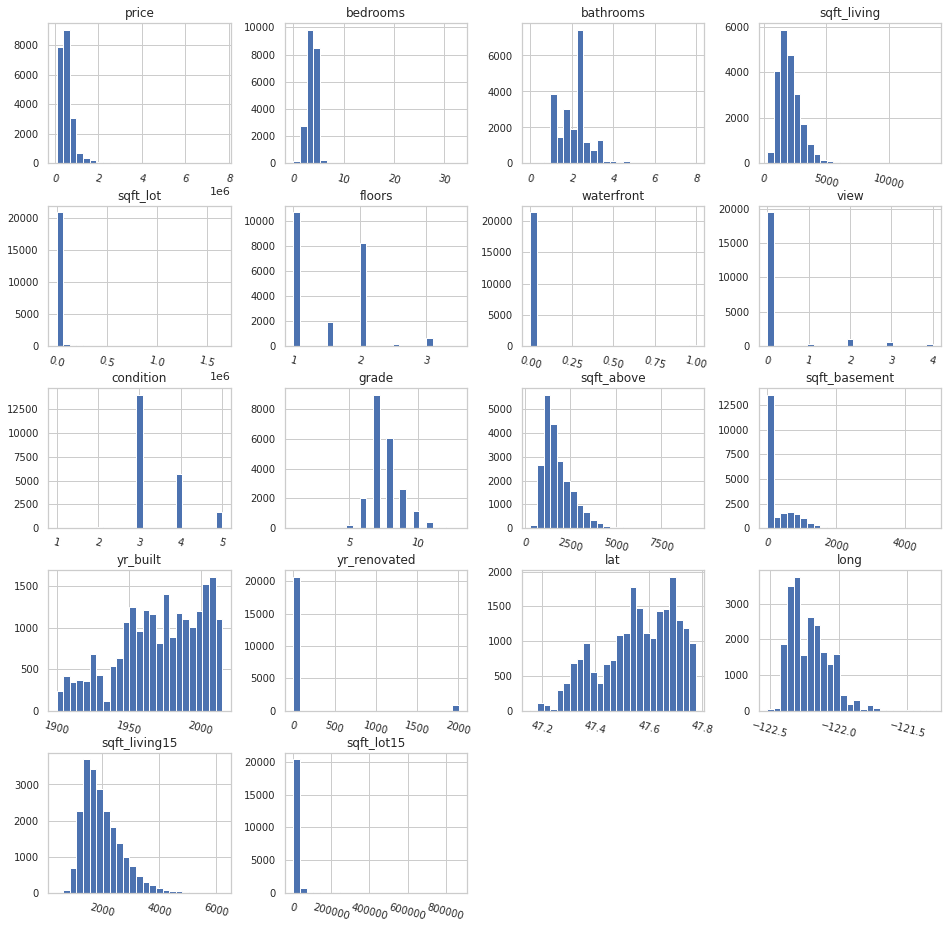

In [ ]:
df1=initial_df[['price', 'bedrooms', 'bathrooms', 'sqft_living',
    'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
    'lat', 'long', 'sqft_living15', 'sqft_lot15']]
h = df1.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
# sns.despine(left=True, bottom=True)
# [x.title.set_size(12) for x in h.ravel()];
# [x.yaxis.tick_left() for x in h.ravel()];

In [ ]:
initial_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,21613.00,4580301520.86,2876565571.31,1000102.00,2123049194.00,3904930410.00,7308900445.00,9900000190.00
price,21613.00,540088.14,367127.20,75000.00,321950.00,450000.00,645000.00,7700000.00
bedrooms,21613.00,3.37,0.93,0.00,3.00,3.00,4.00,33.00
bathrooms,21613.00,2.11,0.77,0.00,1.75,2.25,2.50,8.00
sqft_living,21613.00,2079.90,918.44,290.00,1427.00,1910.00,2550.00,13540.00
sqft_lot,21613.00,15106.97,41420.51,520.00,5040.00,7618.00,10688.00,1651359.00
floors,21613.00,1.49,0.54,1.00,1.00,1.50,2.00,3.50
waterfront,21613.00,0.01,0.09,0.00,0.00,0.00,0.00,1.00
view,21613.00,0.23,0.77,0.00,0.00,0.00,0.00,4.00
condition,21613.00,3.41,0.65,1.00,3.00,3.00,4.00,5.00


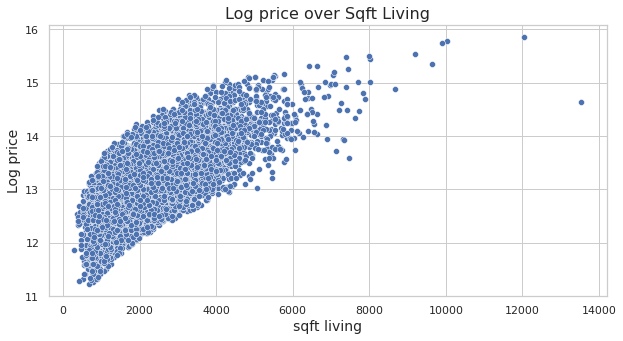

In [ ]:
plt.figure(figsize=(10,5))

y = np.log1p(initial_df.price)
sns.scatterplot(data=initial_df, x='sqft_living',y=y)

plt.ylabel('Log price', fontsize=14)
plt.xlabel('sqft living', fontsize=14)

plt.title('Log price over Sqft Living', fontsize=16)
plt.show()

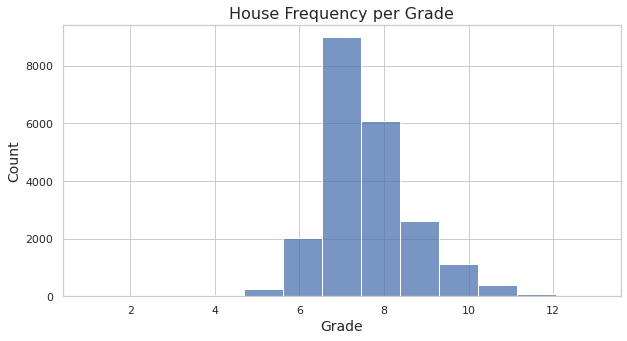

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(data=initial_df, x='grade', bins=13)
plt.title('House Frequency per Grade', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Grade', fontsize=14)

plt.show()

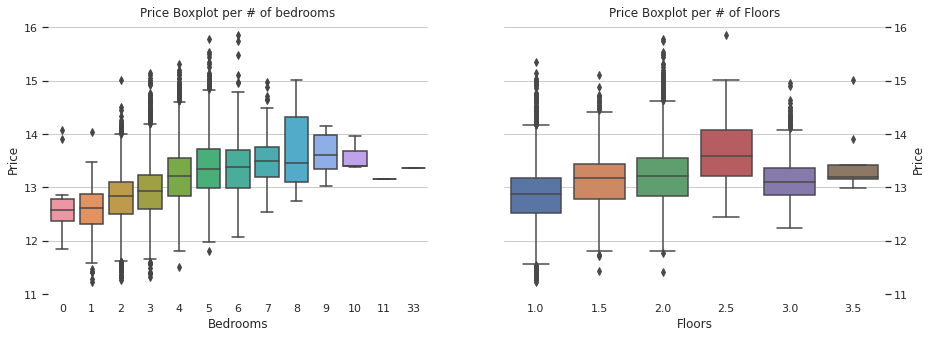

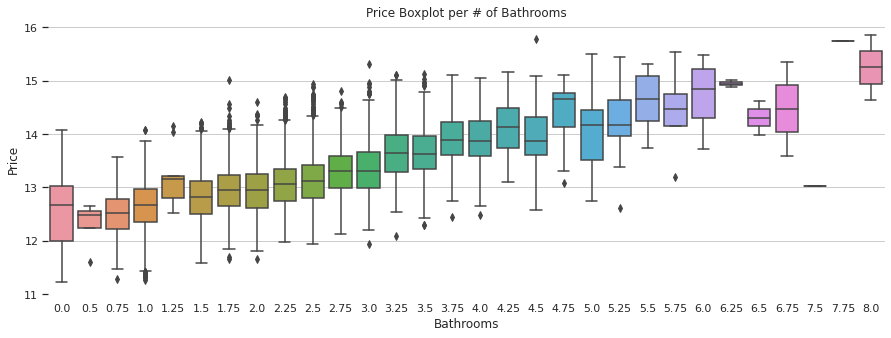

In [ ]:
f, axes = plt.subplots(1, 2,figsize=(15,5))
y = np.log1p(initial_df.price)
sns.boxplot(x=initial_df['bedrooms'],y=y, ax=axes[0])
sns.boxplot(x=initial_df['floors'],y=y, ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Bedrooms', ylabel='Price', title='Price Boxplot per # of bedrooms')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Floors', ylabel='Price', title='Price Boxplot per # of Floors')

f, axe = plt.subplots(1, 1,figsize=(15,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=initial_df['bathrooms'],y=y, ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Bathrooms', ylabel='Price', title='Price Boxplot per # of Bathrooms');

plt.show()

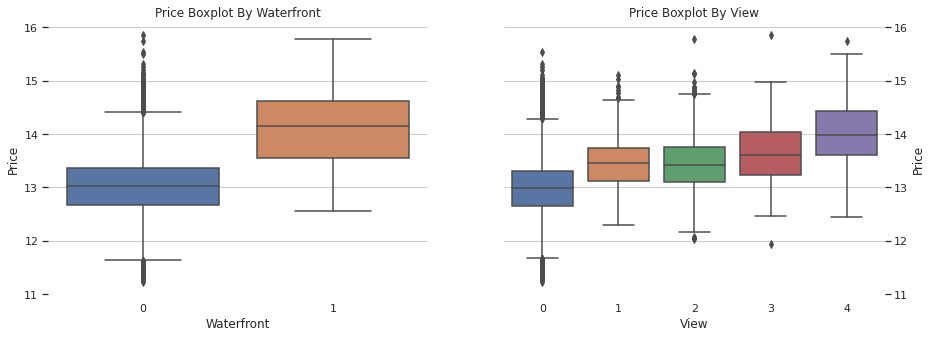

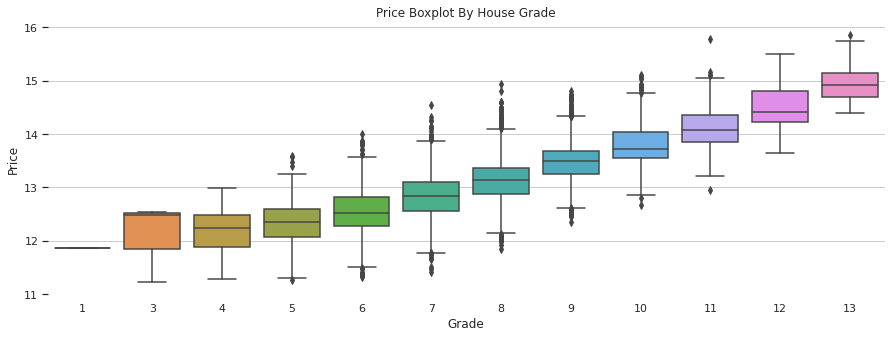

In [ ]:
f, axes = plt.subplots(1, 2,figsize=(15,5))
y = np.log1p(initial_df.price)
sns.boxplot(x=initial_df['waterfront'],y=y, ax=axes[0])
sns.boxplot(x=initial_df['view'],y=y, ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Waterfront', ylabel='Price', title='Price Boxplot By Waterfront')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='View', ylabel='Price', title='Price Boxplot By View' )

f, axe = plt.subplots(1, 1,figsize=(15,5))
sns.boxplot(x=initial_df['grade'],y=y, ax=axe)
sns.despine(left=True, bottom=True)
axe.yaxis.tick_left()
axe.set(xlabel='Grade', ylabel='Price', title='Price Boxplot By House Grade');

plt.show()

In [ ]:
maxpr=initial_df.loc[initial_df['price'].idxmax()]
minpr=initial_df.loc[initial_df['price'].idxmin()]

# define a function to draw a basemap easily
def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start, width='50%', height='50%')
    return base_map

df_copy = initial_df.copy()

df_copy['count'] = 1
basemap = generateBaseMap()
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
# add a marker for the house which has the highest price
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)

folium.Marker([minpr['lat'], minpr['long']],popup='Lowest Price: $'+str(format(minpr['price'],'.0f')),
              icon=folium.Icon(color='red')).add_to(s)
# add heatmap
HeatMap(data=initial_df[['lat', 'long', 'price']].values.tolist(),
        radius=15, blur=20, max_val=maxpr['price'],max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

## Data cleaning



We **found one house** with **33** bedrooms, the **house size is about 120 sqm** this is abviously a typo **we replace the 33 bedrooms to 3 bedrooms**


We found **13 houses with 0 bedrooms** this could mean that data is incomplete since its only 13 houses **we decided to drop those houses**

We found **7 houses with 0 - 0.5 bathrooms**, this is also something we probably should drop.


Thus we are left with exactly 21,593 houses to train and test our model

In [ ]:
initial_df.loc[3538, 'bedrooms'] = 3

initial_df = initial_df.loc[initial_df.bedrooms > 0]

initial_df = initial_df.loc[initial_df.bathrooms > 0.5]

# initial_df = initial_df.loc[initial_df.sqft_living < 10000]

# Feature engineering

### Giving time a value in our data set

The column 'date' is the date of the sale of the properties, in order to use this data we needed to transform it to something usebale, we wanted to give time a value. Thus we calculate the time passed in (monthly units) from the first date till the current sale date.


In [ ]:
initial_df['minimum_date'] = initial_df.iloc[0, 1]
initial_df['months_passed'] = 12 * (initial_df.date.dt.year - initial_df.minimum_date.dt.year) + (initial_df.date.dt.month - initial_df.minimum_date.dt.month)
initial_df.drop(columns='minimum_date', inplace=True)

### Converting from square feet to square meters (sqm)

The feet metrics is less intuitive for as so we decided to convert it to meters.

In Addition we converted the names of the columns

In [ ]:
initial_df[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']] = initial_df[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']].applymap(lambda value: int(value * 0.09290304))
initial_df.rename(columns={'sqft_living': 'sqm_living',
                           'sqft_lot': 'sqm_lot',
                           'sqft_above': 'sqm_above',
                           'sqft_basement': 'sqm_basement',
                           'sqft_living15': 'sqm_living15',
                           'sqft_lot15': 'sqm_lot15'}, inplace=True)


### Finding the house age when it was sold

The column **yr_built** is the year in which the building was built, in order to use this column we decided to subtract the age of the building from the date of the sale.

In [ ]:
initial_df['age'] = initial_df.date.dt.year - initial_df.yr_built

### Giving value to age of renovation

The column **yr_renovated** is the year in which the property was renovated, in order to use this column we decided that if the property has been renovated less then 10 years before the sale the value of 'renovation_grp' would be 1 else it would be 0

In [ ]:
initial_df['renovation_age'] = initial_df.date.dt.year - initial_df.yr_renovated
initial_df.renovation_age.loc[initial_df.renovation_age>=2014] = initial_df.age.loc[initial_df.renovation_age>=2014]

Renovation_min_years = 10
split_grps = 1
split_df = initial_df.loc[initial_df.renovation_age <= Renovation_min_years].renovation_age
renovation_grp = pd.cut(split_df, bins=split_grps, labels=range(split_grps, 0, -1))
initial_df['renovation_grp'] = renovation_grp
initial_df.renovation_grp = initial_df.renovation_grp.astype('float')
initial_df.renovation_grp.fillna(0, inplace=True)
initial_df.renovation_grp = initial_df.renovation_grp.astype('int')
# initial_df.drop(columns='renovation_age', inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Data enrichment

Using an API from http://www.justicemap.org/index.php

**We have added for each house the median income of a household** in the area it was sold **and the percent of white population**.

the data was saved in a pickle file since the extraction takes several minutes to get



### Getting and Loading up a pickled dataframe

In [ ]:
url = 'https://raw.githubusercontent.com/danihello/KingCounty_Regression/main/df_income_race.pkl'

resp = requests.get(url)
binary = resp.content
with open('initial_df.pkl', 'wb') as fh:
    fh.write(binary)

with open('initial_df.pkl','rb') as fh:
    df = pickle.load(fh)

### Merging the income and white percentage to the main data

In [ ]:
initial_df['income'] = df.income
initial_df['white_pct'] = df.white_pct.astype('float')

### Annex of functions used for the API

In [ ]:
#  df['url_api']= 'http://www.spatialjusticetest.org/api.php?fLat='+df.lat.astype('str')+'&fLon='+df.long.astype('str')+'&sGeo=tract'

#def get_income(row):
#    r = requests.get(row)
#    return r.json()['income']

#def get_white(row):
#    r = requests.get(row)
#    return r.json()['white']

# df['white_pct'] = df.url_api.apply(get_white)

## Dropping unnecessary columns

In [ ]:
initial_df.drop(columns=['id', 'date', 'yr_built', 'yr_renovated', 'zipcode'], inplace=True)

## Pearson Correlation Matrix

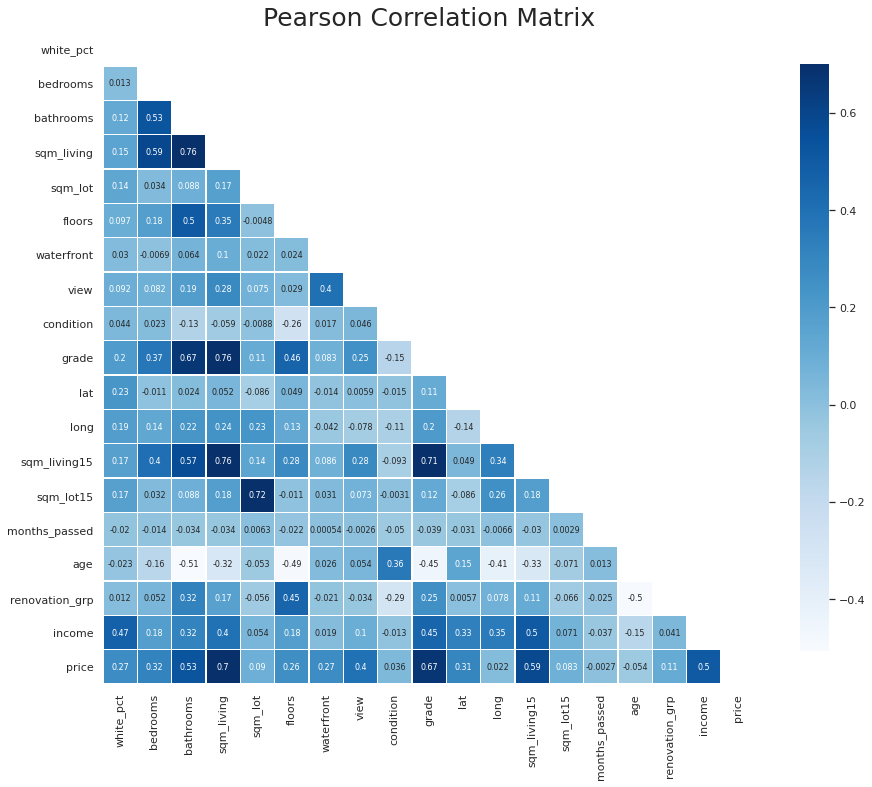

In [ ]:
features = ['white_pct','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront',
            'view','condition','grade','lat','long','sqm_living15','sqm_lot15',
             'months_passed','age','renovation_grp','income','price']

mask = np.zeros_like(initial_df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(initial_df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="Blues", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

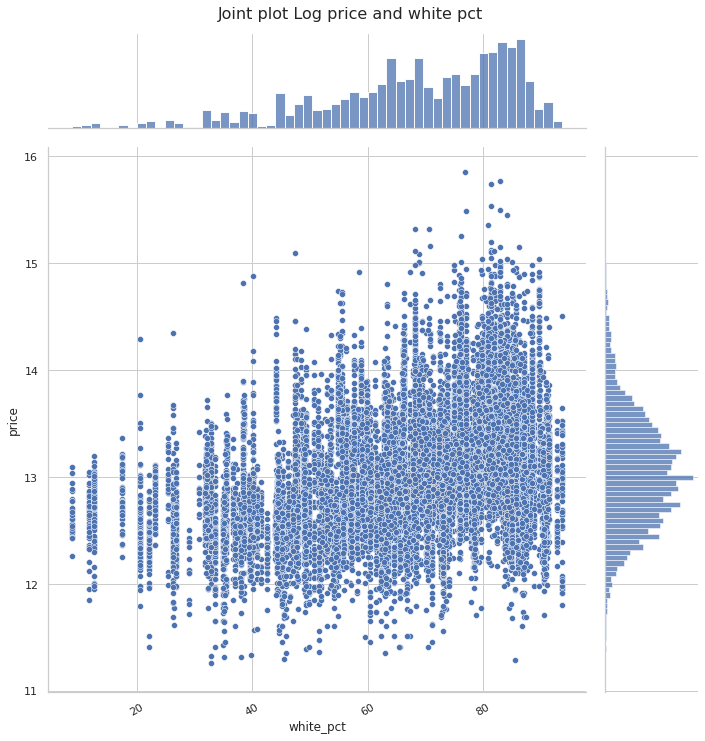

In [ ]:
# sns.set(font_scale=1.5)
ax =  sns.jointplot(data=initial_df, x="white_pct", y=y, kind='scatter', height=10)
plt.suptitle('Joint plot Log price and white pct', fontsize=16, y=1.02)
plt.ylabel('Log Price', fontsize=14)
plt.xlabel('Income', fontsize=14)
for tick in ax.ax_joint.get_xticklabels():         
    tick.set_rotation(30)


# ax =  sns.jointplot(data=initial_df, x="white_pct", y=y, kind='scatter' )
# for tick in ax.ax_joint.get_xticklabels():         
#     tick.set_rotation(30)

# Regression

## Function to support the regression analysis

Since we score alot of models we have decided to use a template (originally made by Aviad in class) to compare diffrenet models.

The function returns rmse, rmsle and rmsp both for thest data and train data

In [ ]:
def model_name(model):
    try:
        return type(model).__name__
    except:
        return type(model.model).__name__

def rmse(a, b):
    return mse(a, b) **0.5

def rmsle(a,b):
    return msle(a,b) ** 0.5

def score_model_(stage, y, y_pred, is_log_scale):


    if not is_log_scale:
        rmse_error = rmse(y, y_pred)
        # MSLE cannot be used with negative values
        rmsle_error = rmsle(y, y_pred.clip(0))    
    else:
        rmsle_error = rmse(y, y_pred)
        rmse_error = rmse(np.expm1(y), np.expm1(y_pred))

    rmsp_error = np.round(100*(np.expm1(rmsle_error)), 2)
    
    return pd.DataFrame({
        f"{stage}_rmse": rmse_error,
        f"{stage}_rmsle": rmsle_error,
        f"{stage}_rms%": rmsp_error
    }, index=[0])

def score_model(model, name, y_train, y_train_pred, y_test, y_test_pred, is_log_scale):
    results = score_model_('train', y_train, y_train_pred, is_log_scale)
    results = results.join(score_model_('test', y_test, y_test_pred, is_log_scale))
    results['model'] = model_name(model)
    results['name'] = name
    return results.set_index(['model', 'name'])

def fit_and_score(models, X_train, y_train, X_test, y_test, is_log_scale):
    df = pd.DataFrame()
    try:
        for model, name in models:
            try:
                model.fit(X_train, y_train)
            except:
                model.model.fit(X_train, y_train)

            try:
                y_train_pred = model.predict(X_train)
                y_test_pred = model.predict(X_test)
            except:
                y_train_pred = model.model.predict(X_train)
                y_test_pred = model.model.predict(X_test)
            results = score_model(model, name, y_train, y_train_pred,  y_test, y_test_pred, is_log_scale)
            df = df.append(results)
    except:
        for model in models:
            try:
                model.fit(X_train, y_train)
            except:
                model.model.fit(X_train, y_train)

            try:
                y_train_pred = model.predict(X_train)
                y_test_pred = model.predict(X_test)
            except:
                y_train_pred = model.model.predict(X_train)
                y_test_pred = model.model.predict(X_test)
            results = score_model(model, '', y_train, y_train_pred,  y_test, y_test_pred, is_log_scale)
            df = df.append(results)
            
    return df

In [ ]:
def show_feature_importance(features, model):
    feature_score_df = pd.DataFrame({'score':model.feature_importances_ * 100, 'name':features}).sort_values('score', ascending=False)
    plt.figure(figsize=(10,5))
    ax = sns.barplot(data=feature_score_df, y='name', x='score', orient = 'h')
    plt.ylabel('feature', fontsize=14)
    plt.xlabel('normalized score', fontsize=14)
    plt.title('Feature Importance', fontsize=20)
    return ax


## Using Simple Regression as Benchmark

Our initial accuracy is a mse of ~$250K (around 50% accuracy)

This is our benchmark for all the following regressions 

In [ ]:
simple_regression = LinearRegression()

X, y  = initial_df.sqm_living.values.reshape(-1, 1), initial_df.price
X_train, X_test, y_train, y_test = train_test_split(X, y)
fit_and_score([(simple_regression, 'simple linear regression')],X_train, y_train, X_test, y_test, is_log_scale=False)

,,train_rmse,train_rmsle,train_rms%,test_rmse,test_rmsle,test_rms%
model,name,,,,,,
LinearRegression,simple linear regression,259574.63,0.41,50.47,267250.11,0.41,50.71


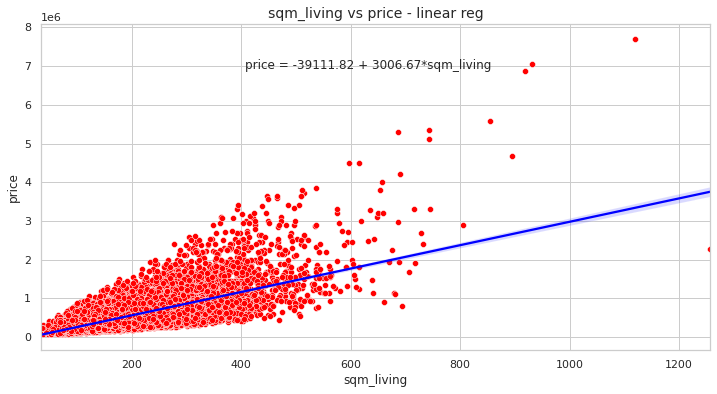

In [ ]:
a, b = simple_regression.intercept_, float(simple_regression.coef_)
index_max = initial_df.price.idxmax

point = (initial_df.loc[index_max, 'sqm_living'], initial_df.loc[index_max, 'price'])

plt.figure(figsize=(12, 6))
sns.scatterplot(data = initial_df, x='sqm_living', y='price', color='red')
sns.regplot(data = initial_df, x='sqm_living', y='price', color='blue', scatter=False)
plt.title('sqm_living vs price - linear reg', fontsize=14)

anot_location_x = (initial_df.sqm_living.max() - initial_df.sqm_living.min()) / 3 
anot_location_y = initial_df.price.max() * 0.9
plt.annotate(f'price = {a:.2f} + {b:.2f}*sqm_living', point, (anot_location_x, anot_location_y))
plt.show()

## Spliting the data and preproccesing the label

We exclude sqm_above and sqm_basement becuase: sqm_living = sqm_above + sqm_basement

In [ ]:
features = [
  'bedrooms'
,'bathrooms'
, 'sqm_living'
, 'sqm_lot'
, 'floors'
, 'waterfront'
, 'view'
, 'condition'
, 'grade'
# , 'sqm_above'
# , 'sqm_basement'
, 'lat'
, 'long'
, 'sqm_living15'
, 'sqm_lot15'
, 'months_passed'
, 'age'
, 'renovation_grp'
, 'income'
, 'white_pct'
# ,'renovation_age'
]

In [ ]:
X, y  = initial_df.loc[:,features], initial_df.price

y_log = np.log1p(y)

test_size=0.25

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test)

##DecisionTreeRegressor

We first use **DecisionTree** model to improve upon our benchmark

we focus both on a **label and a log transformation of the label**

Further on, we **chose hyper parameters** in such way that the model will **minimize rms% for the test data**, and also to **prevent the model from overfitting** (default parameters of a decision tree overfit it).

in order to optimize accuracy we iterate over 3 hyper-parameters with varying ranges:


finnaly we set the hyper parameters to be:

*   max_leaf_nodes = 452
*   max_depth = 12
*   min_samples_leaf = 14




In [ ]:
def score_hyper_p2(X_train, y_train, X_test, y_test, is_log_scale):
    depth_range = range(2,20,2)
    leaf_nodes = range(2,500,15)
    sample_range = range(2,20,2)
    result = []
    for depth in depth_range:
        for node in leaf_nodes:
            for leaf in sample_range:
                model = DecisionTreeRegressor(max_depth=depth, max_leaf_nodes=node, min_samples_leaf=leaf)
                test_rms_pct = fit_and_score([model], X_train, y_train, X_test, y_test, is_log_scale=is_log_scale)['test_rms%'][0]
                result.append({'test_rms%':test_rms_pct, 'depth':depth, 'node':node, 'leaf': leaf})
    return pd.DataFrame(data=result)

In [ ]:
# result = score_hyper_p2(X_train, y_train_log, X_test, y_test_log, is_log_scale=True)
# result.loc[result['test_rms%'].idxmin()]

In [ ]:
model_dt = DecisionTreeRegressor()
model_dt_hype = DecisionTreeRegressor(max_leaf_nodes=407, max_depth=14, min_samples_leaf=6)


Comparing models with regular label

In [ ]:
fit_and_score([(simple_regression, 'Simple Linear Regression' ),
               (model_dt, 'defult'),
               (model_dt_hype, 'max_leaf_nodes=407, max_depth=14, min_samples_leaf=6')]
            ,X_train, y_train, X_test, y_test, is_log_scale=False)

train_rmse  ...  test_rms%
model                 name                                                            ...           
LinearRegression      Simple Linear Regression                             191855.54  ...     170.66
DecisionTreeRegressor defult                                                   17.95  ...      28.20
                      max_leaf_nodes=407, max_depth=14, min_samples_l...   113994.40  ...      23.89

[3 rows x 6 columns]

Comparing models with Log transformed label

In [ ]:
fit_and_score([(simple_regression, 'Simple Linear Regression' ),
               (model_dt, 'defult'),
               (model_dt_hype, 'max_leaf_nodes=452, max_depth=12, min_samples_leaf=14')]
              ,X_train, y_train_log, X_test, y_test_log, is_log_scale=True)

train_rmse  ...  test_rms%
model                 name                                                            ...           
LinearRegression      Simple Linear Regression                             186885.31  ...      25.89
DecisionTreeRegressor defult                                                   20.71  ...      28.67
                      max_leaf_nodes=452, max_depth=12, min_samples_l...   123633.14  ...      23.85

[3 rows x 6 columns]

We find that the Decision Tree models can reduce the error from **50% to ~23%-24%**

We also found **no real improvement** whether we use Log transformation on the label in the case of a Decision Tree, however it greatly improves the linear rgression model.

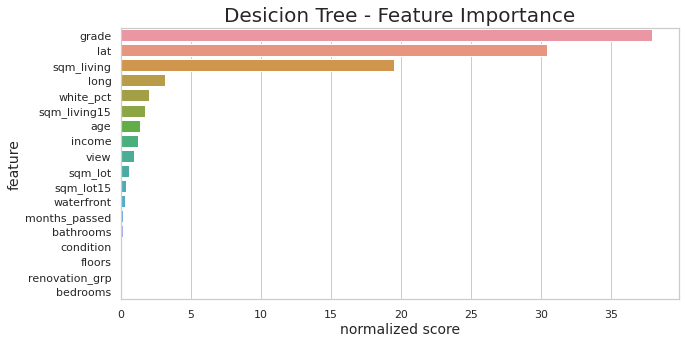

In [ ]:
show_feature_importance(X.columns, model_dt_hype)
plt.title('Desicion Tree - Feature Importance', fontsize=20)
plt.show()

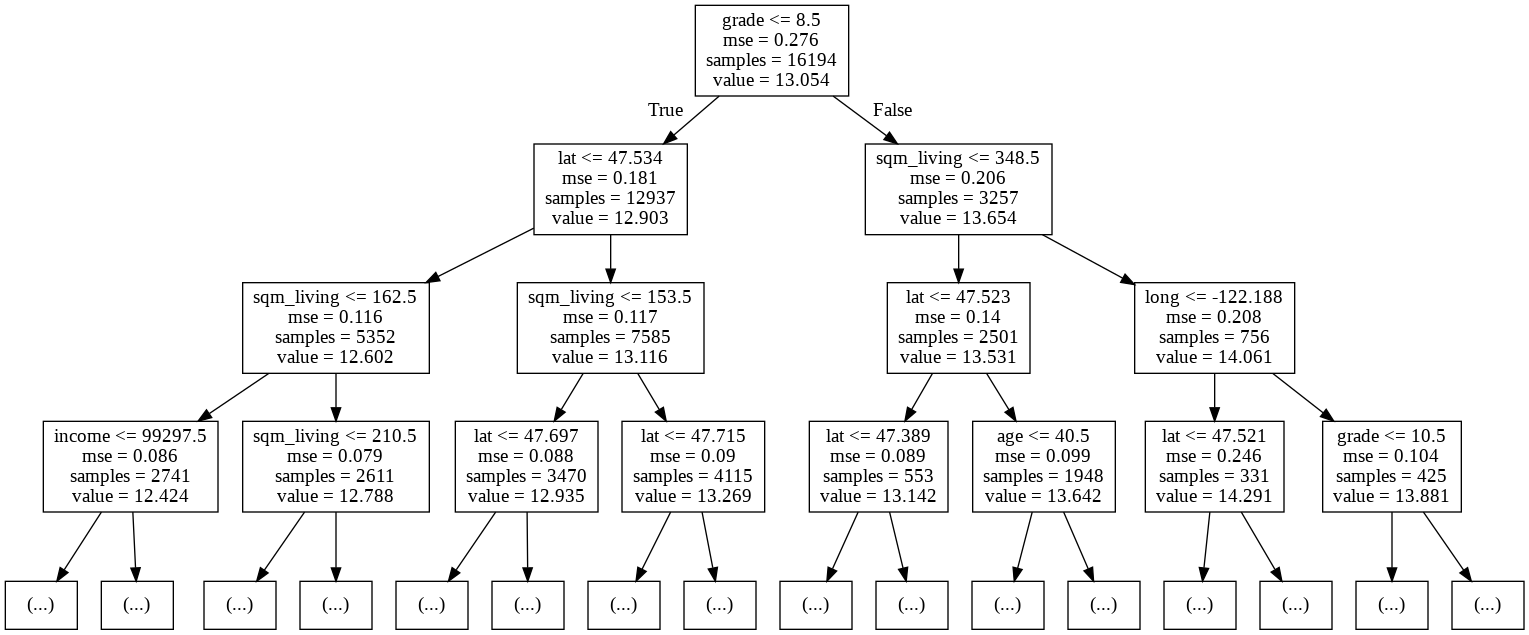

In [ ]:
dot_data = StringIO()  
export_graphviz(model_dt, out_file=dot_data, feature_names=X.columns, leaves_parallel=True, max_depth=3)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=1500, height=500) 

## Random Forest

We use a Random Forest model to further improve upon what we did in the decision tree

In [ ]:
model_rf = RandomForestRegressor(n_estimators=100, max_samples=5000, min_samples_leaf=5)

### Fitting and scoring for price

In [ ]:
fit_and_score([simple_regression, model_dt_hype ,model_rf],X_train, y_train, X_test, y_test, is_log_scale=False)

,,train_rmse,train_rmsle,train_rms%,test_rmse,test_rmsle,test_rms%
model,name,,,,,,
LinearRegression,,191855.54,0.92,149.97,196172.87,1.00,170.66
DecisionTreeRegressor,,113994.40,0.18,19.36,151918.06,0.21,23.89
RandomForestRegressor,,119513.39,0.15,16.65,139674.45,0.18,19.72


### Fitting and scoring for Log price

In [ ]:
fit_and_score([simple_regression, model_dt ,model_rf],X_train, y_train_log, X_test, y_test_log, is_log_scale=True)

,,train_rmse,train_rmsle,train_rms%,test_rmse,test_rmsle,test_rms%
model,name,,,,,,
LinearRegression,,186885.31,0.23,25.91,171269.39,0.23,25.89
DecisionTreeRegressor,,20.71,0.00,0.01,173351.85,0.25,28.49
RandomForestRegressor,,128177.95,0.15,16.61,150058.52,0.18,19.89


Explanation how we chose hyper parameters:

In [ ]:
# old version lets you run one parameter at a time
def score_hyper_p(X_train, y_train, X_test, y_test, is_log_scale):
    parameter_range = range(1,20,2)
    result = []
    for i in parameter_range:
        model = RandomForestRegressor(n_estimators=100, max_samples=5000, max_depth=i)
        test_rms_pct = fit_and_score([model], X_train, y_train, X_test, y_test, is_log_scale=is_log_scale)['test_rms%'][0]
        result.append(test_rms_pct)
        data = {'test_rms%': result}
    return pd.DataFrame(data=data, index=parameter_range).plot()

In [ ]:
# new version runs all options between 3 hyper parameters
def score_hyper_rf(X_train, y_train, X_test, y_test, is_log_scale):
    tree_range = range(10,100,10)
    samples_range = range(1000,15000,1000)
    leaf_range = range(2,20,2)
    result = []
    for tree in tree_range:
        for sample in samples_range:
            for leaf in leaf_range:
                model = RandomForestRegressor(n_estimators=tree, max_samples=sample, min_samples_leaf=leaf)
                test_rms_pct = fit_and_score([model], X_train, y_train, X_test, y_test, is_log_scale=is_log_scale)['test_rms%'][0]
                result.append({'test_rms%':test_rms_pct, 'trees':tree, 'samples':sample, 'sample_leaf': leaf})
    return pd.DataFrame(data=result)

In [ ]:
# result = score_hyper_rf(X_train, y_train_log, X_test, y_test_log, is_log_scale=True)

In [ ]:
# result.loc[result['test_rms%'].idxmin()]

In [ ]:
# score_hyper_p(X_train, y_train, X_test, y_test, is_log_scale=False)

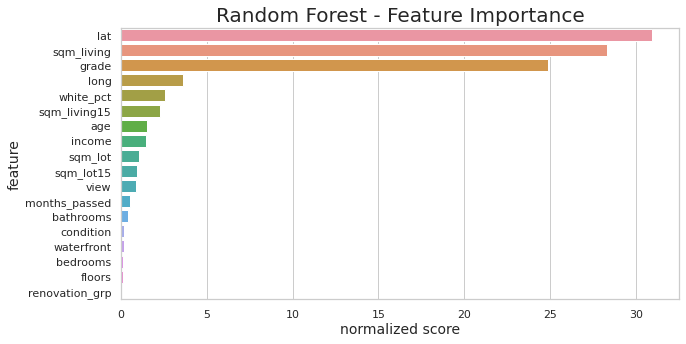

In [ ]:
show_feature_importance(X.columns, model_rf)
plt.title('Random Forest - Feature Importance', fontsize=20)
plt.show()

## Ratio Models

We now try and predict price per sqm_living and price per Grade and also a combo of the two

In [ ]:
class Sqm_livingRatioRegressor:
    def __init__(self, **kwargs):
        self.model = RandomForestRegressor(**kwargs)

    def fit(self, X, y):
        y_train = y / X['sqm_living']
        self.model.fit(X, y_train)
        self.feature_importances_ = self.model.feature_importances_
        return self

    def predict(self, X):
        return (self.model.predict(X) * X['sqm_living'])

class GradeRatioRegressor:
    def __init__(self, **kwargs):
        self.model = RandomForestRegressor(**kwargs)
        
    def fit(self, X, y):
        y_train = y / X['grade']
        self.model.fit(X, y_train)
        self.feature_importances_ = self.model.feature_importances_
        return self

    def predict(self, X):
        return (self.model.predict(X) * X['grade'])

class GeneralRatioRegressor:
    def __init__(self, **kwargs):
        self.Sqm_living_model = GradeRatioRegressor(**kwargs)
        self.grade_model = Sqm_livingRatioRegressor(**kwargs)
        self.feature_importances_ = 0
        
    def fit(self, X, y):
        self.Sqm_living_model.fit(X, y)
        self.grade_model.fit(X, y)
        self.feature_importances_ = self.Sqm_living_model.model.feature_importances_ * 0.5 + self.grade_model.model.feature_importances_ * 0.5
        return self

    def predict(self, X):
        y = self.Sqm_living_model.predict(X)*0.5 + self.grade_model.predict(X)*0.5
        return y

In [ ]:
ratio_living = Sqm_livingRatioRegressor(n_estimators=100, max_samples=5000, min_samples_leaf=5)
ratio_grade = GradeRatioRegressor(n_estimators=100, max_samples=5000, min_samples_leaf=5)
general_ratio = GeneralRatioRegressor(n_estimators=100, max_samples=5000, min_samples_leaf=5)

### Fitting and scoring for price

In [ ]:
fit_and_score([simple_regression, model_dt_hype ,model_rf, ratio_living, ratio_grade, general_ratio],X_train, y_train, X_test, y_test, is_log_scale=False)

,,train_rmse,train_rmsle,train_rms%,test_rmse,test_rmsle,test_rms%
model,name,,,,,,
LinearRegression,,191855.54,0.92,149.97,196172.87,1.00,170.66
DecisionTreeRegressor,,113994.40,0.18,19.36,151923.22,0.21,23.89
RandomForestRegressor,,122424.22,0.15,16.70,142607.59,0.18,19.88
Sqm_livingRatioRegressor,,107528.57,0.15,16.49,119049.54,0.18,19.47
GradeRatioRegressor,,112697.38,0.15,16.07,131407.82,0.17,19.05
GeneralRatioRegressor,,105899.63,0.15,15.79,120724.45,0.17,18.70


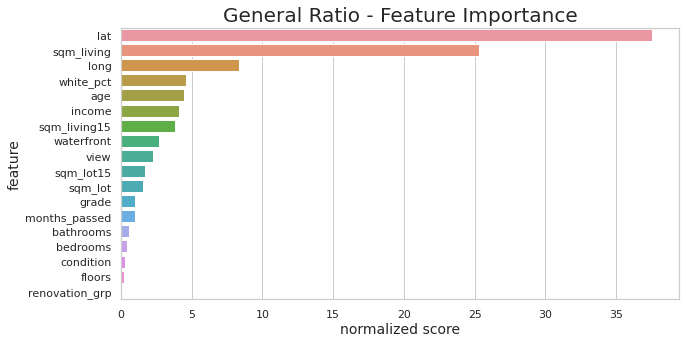

In [ ]:
show_feature_importance(X_train.columns, general_ratio)
plt.title('General Ratio - Feature Importance', fontsize=20)
plt.show()

### Fitting and scoring for Log price

In [ ]:
fit_and_score([simple_regression, model_dt_hype ,model_rf, ratio_living, ratio_grade, general_ratio],X_train, y_train_log, X_test, y_test_log, is_log_scale=True)

,,train_rmse,train_rmsle,train_rms%,test_rmse,test_rmsle,test_rms%
model,name,,,,,,
LinearRegression,,186885.31,0.23,25.91,171269.39,0.23,25.89
DecisionTreeRegressor,,123633.14,0.17,18.55,165951.69,0.21,23.85
RandomForestRegressor,,130951.23,0.15,16.67,154658.89,0.18,19.95
Sqm_livingRatioRegressor,,938122144.46,0.22,24.82,108564604.28,0.25,28.50
GradeRatioRegressor,,153309.77,0.16,17.74,162847.08,0.20,21.95
GeneralRatioRegressor,,4178603.67,0.18,19.31,2812355.60,0.21,22.76


## Adding Price per sqm_living as a feature

In [ ]:
lr = LinearRegression()
lr.fit(X_train, np.log1p(y_train))

X_boost = X.copy()
X_boost['y_pred_lin'] = pd.Series(data=np.expm1(lr.predict(X)),index=X.index) /  initial_df.sqm_living

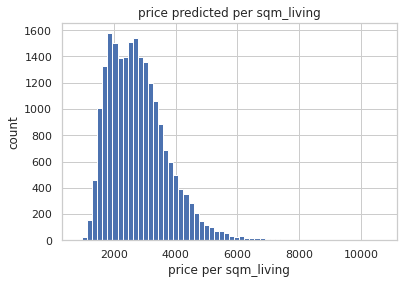

In [ ]:
(pd.Series(data=np.expm1(lr.predict(X)),index=X.index) / initial_df.sqm_living).hist(bins=60)
plt.title('price predicted per sqm_living')
plt.xlabel('price per sqm_living')
plt.ylabel('count')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_boost, y, test_size=test_size, random_state=1)
y_test_log = np.log1p(y_test)
y_train_log = np.log1p(y_train)

### Fitting and scoring for price

In [ ]:
fit_and_score([simple_regression, model_dt_hype ,model_rf, ratio_living, ratio_grade, general_ratio],X_train, y_train, X_test, y_test, is_log_scale=False)

,,train_rmse,train_rmsle,train_rms%,test_rmse,test_rmsle,test_rms%
model,name,,,,,,
LinearRegression,,184371.43,0.48,60.95,185105.45,0.55,72.54
DecisionTreeRegressor,,110909.13,0.18,19.18,158755.49,0.21,23.70
RandomForestRegressor,,115863.43,0.15,16.37,136073.84,0.18,19.61
Sqm_livingRatioRegressor,,111356.52,0.15,15.76,116088.67,0.17,18.77
GradeRatioRegressor,,110935.94,0.15,15.95,130282.21,0.17,19.09
GeneralRatioRegressor,,105218.78,0.14,15.49,119151.24,0.17,18.49


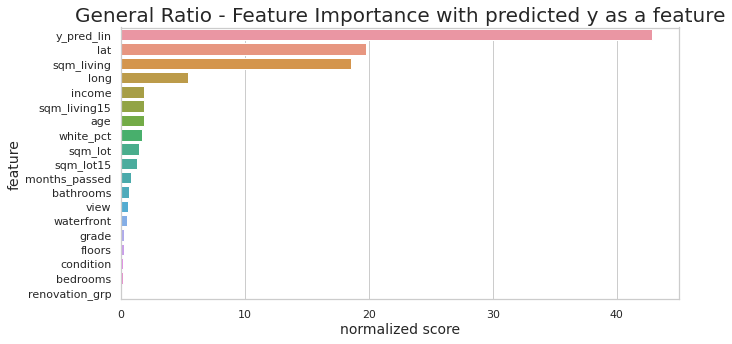

In [ ]:
show_feature_importance(X_train.columns, general_ratio)
plt.title('General Ratio - Feature Importance with predicted y as a feature', fontsize=20)
plt.show()

#### An approach to find the optimal weights for General ratio

We perform a linear regression between the predictions made by grade_ratio and living_sqml_ratio

Then let it decide the best weights

In [ ]:

lr_weights = LinearRegression(fit_intercept=False)

y_pred_grade =ratio_grade.predict(X_train)
y_pred_sqm_living =ratio_living.predict(X_train)

X_of_y = pd.DataFrame({'y_pred_grade':y_pred_grade, 'y_pred_sqm_living':y_pred_sqm_living, 'y':y_train})

lr_weights.fit(X_of_y.iloc[:,:-1], y_train)

Prediction_weights = lr_weights.coef_ * 100 / lr_weights.coef_.sum()
Prediction_weights


array([52.12407227, 47.87592773])

### Fitting and scoring for Log price

In [ ]:
fit_and_score([simple_regression, model_dt_hype,model_rf, ratio_living, ratio_grade, general_ratio],X_train, y_train_log, X_test, y_test_log, is_log_scale=True)

,,train_rmse,train_rmsle,train_rms%,test_rmse,test_rmsle,test_rms%
model,name,,,,,,
LinearRegression,,167245.65,0.23,25.68,160904.26,0.23,25.73
DecisionTreeRegressor,,122045.44,0.17,18.32,165110.32,0.21,23.42
RandomForestRegressor,,122481.89,0.15,16.27,142927.69,0.18,19.59
Sqm_livingRatioRegressor,,800796611.35,0.21,23.25,100758324.50,0.24,26.68
GradeRatioRegressor,,152517.60,0.16,17.44,159785.34,0.20,21.55
GeneralRatioRegressor,,4520679.54,0.17,18.56,3272180.32,0.20,21.93


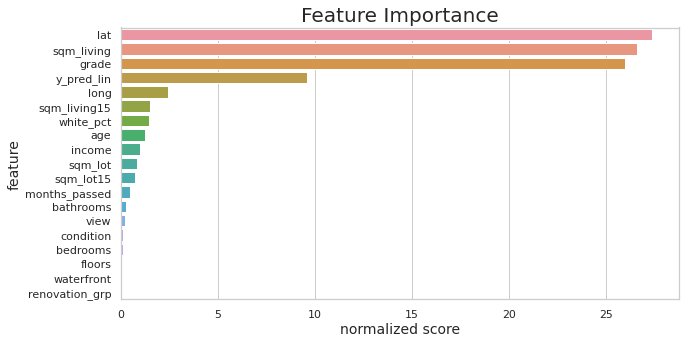

In [ ]:
show_feature_importance(X_train.columns, model_rf)

plt.show()